For anmiation of GOL in python https://www.geeksforgeeks.org/conways-game-life-python-implementation/

# Implementing GOL

In [1]:
import sys
sys.path.append('/home/tomi/venv/lib/python3.8/site-packages')
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# setting up the values for the grid
ON = 255
OFF = 0
vals = [ON, OFF]
 
def randomGrid(N):
 
    """returns a grid of NxN random values"""
    return np.random.choice(vals, N*N, p=[0.4, 0.6]).reshape(N, N)

def update(steps,grid, N):
 
    # copy grid since we require 8 neighbors
    # for calculation and we go line by line
  
    for s in range(steps):
        newGrid = grid.copy()
        for i in range(N):
            for j in range(N):

                # compute 8-neghbor sum
                # using toroidal boundary conditions - x and y wrap around
                # so that the simulaton takes place on a toroidal surface.
                total = int((grid[i, (j-1)%N] + grid[i, (j+1)%N] +
                             grid[(i-1)%N, j] + grid[(i+1)%N, j] +
                             grid[(i-1)%N, (j-1)%N] + grid[(i-1)%N, (j+1)%N] +
                             grid[(i+1)%N, (j-1)%N] + grid[(i+1)%N, (j+1)%N])/255)
                
                # apply Conway's rules
                if grid[i, j]  == ON:
                    if (total < 2) or (total > 3):
                        newGrid[i, j] = OFF
                else:
                    if total == 3:
                        newGrid[i, j] = ON

        # update data
        grid[:] = newGrid[:]
    return(grid[:])

def timeseries(numofsteps,grid,N):
    series= []
    series.append(grid.copy())
    for s in range(numofsteps):
        update(1,grid,N)
        series.append(grid.copy())
    return(series)


    

In [3]:
grid=np.array([[255,0,0],[255,0,0],[255,0,0]])
print(grid)
update(1,grid,3)

[[255   0   0]
 [255   0   0]
 [255   0   0]]


array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]])

In [4]:
N=30
steps=1
grid = randomGrid(N)
np.save("./timeseriesdata",timeseries(steps,grid,N))

(100, 100)
0


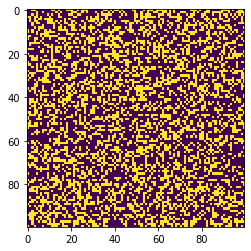

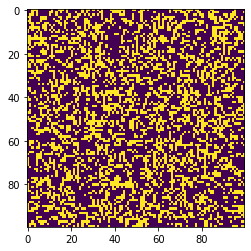

In [5]:
N=100
fig, ax = plt.subplots()
grid=randomGrid(N)
print(grid.shape)
#grid=np.array([[255,0,0,0,0],[0,0,255,0,0],[0,255,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
img = ax.imshow(grid, interpolation='nearest')
for i in range(1):
    print(i)
    fig, ax = plt.subplots()
    update(1,grid,N)
    ax.imshow(grid, interpolation='nearest')

# Implementing some learning
See this for reference https://arxiv.org/pdf/1807.10300.pdf  
Tensorflow intro: https://www.tensorflow.org/tutorials/quickstart/beginner  
Loss functions: https://keras.io/api/losses/  
2D Convolutional layer: https://keras.io/api/layers/convolution_layers/convolution2d/  
for periodic padding see: https://stackoverflow.com/questions/39088489/tensorflow-periodic-padding  

Input: 3x3 layer  
Then either convolutional layers, or dense layers (or both).  
Output should by the probabilities of the central cell being ON or OFF  
i.e. last layer output of size 2 with 'softmax' activation  

In [17]:
#generating a training and test dataset
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

#defining the learning model
numofgrids=50000
dimx=5
dimy=5
t=1
middle=(np.floor(dimx/2),np.floor(dimy/2))
(x_train,y_train)=([],[])
for i in range(numofgrids):
    grid=randomGrid(dimx)
    x_train.append(grid[int(np.floor(dimx/2)-1):int(np.floor(dimx/2)+2),int(np.floor(dimy/2)-1):int(np.floor(dimy/2)+2)].copy())
    grid_=update(t,grid,dimy).copy()
    y_train.append([grid_[int(np.floor(dimx/2)),int(np.floor(dimx/2))].copy(), 255-grid_[int(np.floor(dimx/2)),int(np.floor(dimx/2))].copy()])

x_train =np.array(x_train).reshape(numofgrids,3,3,1)/255
y_train =np.array(y_train).reshape(numofgrids,2)/255

print(x_train[0])
print(y_train[0])

[[[0.]
  [0.]
  [1.]]

 [[0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [0.]]]
[1. 0.]


In [18]:
np.sum(y_train,axis=0)/np.sum(y_train)

array([0.36224, 0.63776])

In [19]:
# Making a balanced dataset (50/50 ON/OFF)
no_of_offs = int(np.sum(y_train,axis=0)[0])
on_indices = np.where(y_train[:,1]==1)[0]
off_indices = np.where(y_train[:,1]==0)[0]
on_indices_cut = on_indices[:no_of_offs]

x_train = np.concatenate((x_train[on_indices_cut,:], x_train[off_indices,:]))
y_train = np.concatenate((y_train[on_indices_cut,:], y_train[off_indices,:]))

p = np.random.permutation(x_train.shape[0])
x_train = x_train[p,:]
y_train = y_train[p,:]

print(x_train.shape)
print(y_train.shape)

(36224, 3, 3, 1)
(36224, 2)


In [20]:
# Data preprocessing: adding the sum of neighbors as an extra feature, and then doing standard scaling (mean 0 and std dev 1 for each feature)

from sklearn import preprocessing

#ratios = np.sum(y_train,axis=0)/np.sum(y_train)

#class_weight = {0: ratios[1], 1: ratios[0]}

x_train = x_train.reshape(x_train.shape[0],-1)
print(x_train.shape)
sums = np.sum(x_train,axis=1)
sums = sums-y_train[:,0]
sums = np.expand_dims(sums, axis=-1)
print(sums.shape)
x_train = np.concatenate((x_train,sums), axis=-1)
print(x_train.shape)

#scaler = preprocessing.StandardScaler().fit(x_train)
#x_scaled = scaler.transform(x_train)
x_scaled=  x_train

(36224, 9)
(36224, 1)
(36224, 10)


In [21]:
"""
tf.keras.layers.Conv2D(9,3,
        input_shape=(3,3,1),
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation=None,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None),
tf.keras.layers.Flatten(),
"""
rate = 0.0 # a rate of 0.1-0.2 actually helps a few percent.
modelA = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dense(2,activation="softmax")
])


#print(tf.nn.softmax(predictions).numpy())
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
modelA.compile(optimizer='sgd',
              loss=loss_fn,
              metrics=[tf.keras.metrics.BinaryAccuracy()])
modelA.fit(x_scaled, y_train, epochs=10)#, class_weight=class_weight)
predictions = modelA(x_scaled)#.numpy()
predictions[0]

Train on 36224 samples
Epoch 1/10
36224/36224 [==============================] - 1s 40us/sample - loss: 0.1199 - binary_accuracy: 0.9500
Epoch 2/10
36224/36224 [==============================] - 1s 40us/sample - loss: 0.0012 - binary_accuracy: 1.0000
Epoch 3/10
36224/36224 [==============================] - 1s 38us/sample - loss: 4.8478e-04 - binary_accuracy: 1.0000
Epoch 4/10
 5376/36224 [===>..........................] - ETA: 1s - loss: 3.5002e-04 - binary_accuracy: 1.0000

KeyboardInterrupt: 

In [15]:
preds = modelA.predict(x_scaled)
preds = np.round(preds)

/home/tomi/venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [16]:
# Check some random elements to see what's up
i=np.random.choice(x_scaled.shape[0])
print(i)
true_original = x_train[i,0:9].reshape(3,3)
print("Input grid:")
print(true_original)
true_updated = update(1,true_original*255,3)/255
print("Updated grid based on Conway rule:")
print(true_updated)
print("\nMiddle point From->To transition")
print("Ground truth, form rule:        ",[true_original[1,1],true_updated[1,1]])
print("Ground truth, form training set:",[true_original[1,1],y_train[i][0]])
print("Prediction of model:            ",[true_original[1,1],preds[i][0]])

17130
Input grid:
[[1. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]
Updated grid based on Conway rule:
[[1. 0. 0.]
 [1. 1. 0.]
 [0. 0. 1.]]

Middle point From->To transition
Ground truth, form rule:         [1.0, 1.0]
Ground truth, form training set: [1.0, 1.0]
Prediction of model:             [1.0, 1.0]


In [6]:
grid=np.array([[1,0,0],[0,0,0],[1,0,1]])
print(grid)
modelA(grid.reshape(1,3,3,1)).numpy()



[[1 0 0]
 [0 0 0]
 [1 0 1]]


array([[0.6196021 , 0.38039795]], dtype=float32)

In [7]:
np.floor(3.4)

3.0

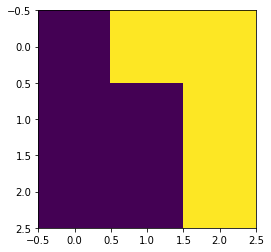

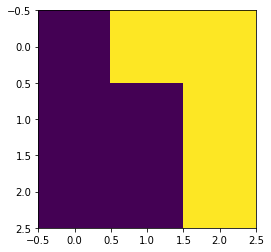

In [8]:

N=3
time=1
grid=randomGrid(N)

gridev=timeseries(time,grid,N)
for t in range(time+1):
    fig, ax = plt.subplots()
    fig=ax.imshow(gridev[t], interpolation='nearest')

[[255   0   0]
 [  0 255   0]
 [255   0   0]]
[[255 255 255]
 [255 255 255]
 [255 255 255]]


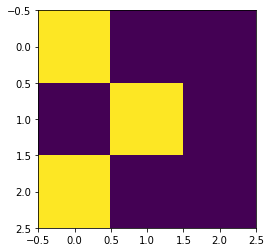

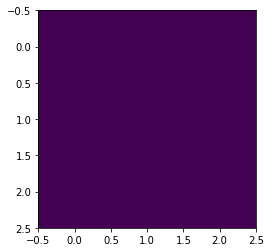

In [9]:

N=3
time=1
grid=np.array([[255,0,0],[0,255,0],[255,0,0]])
#grid=np.array([[0,0,0,0,0],[0,255,0,0,0],[0,0,255,0,0],[0,255,0,0,0],[0,0,0,0,0]])
gridev=timeseries(time,grid,N)

for t in range(time+1):
    print(gridev[t])
    fig, ax = plt.subplots()
    fig=ax.imshow(gridev[t], interpolation='none')

In [10]:
np.zeros((5,5))[int(np.floor(5/2)-1):int(np.floor(5/2)+2),int(np.floor(5/2)-1):int(np.floor(5/2)+2)]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [11]:
int(np.floor(5/2)-1),int(np.floor(5/2)+2)

(1, 4)

In [12]:
np.zeros((5,5))[1:4,1:4]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [13]:
dimx=5
dimy=5
t=1
(x_train,y_train)=([],[])
grid=randomGrid(dimx)
print(grid)
x_train.append(grid[int(np.floor(dimx/2)-1):int(np.floor(dimx/2)+2),int(np.floor(dimy/2)-1):int(np.floor(dimy/2)+2)].copy())
grid_=update(t,grid,dimy).copy()
print(grid_)
y_train.append(grid_[int(np.floor(dimx/2)),int(np.floor(dimx/2))].copy())
print(x_train)
print(y_train)

[[  0   0 255   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0 255   0   0   0]
 [255   0   0   0 255]]
[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [255   0   0   0   0]
 [255 255   0   0   0]]
[array([[  0,   0,   0],
       [  0,   0,   0],
       [255,   0,   0]])]
[0]
